In [1180]:
# 1. Import thư viện
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, 
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

from sklearn.utils.class_weight import compute_sample_weight

In [1181]:
# 2. Đọc file (đã scale = RobustScaling)
data = pd.read_csv("preprocessed_data.csv")
data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,hour,month,weather_group,temperature_2m_lag1,...,relative_humidity_2m_lag2,surface_pressure_lag1,surface_pressure_lag2,pressure_trend,humidity_change,hour_sin,hour_cos,dew_point_gap,pressure_trend_6h,humidity_roll_mean_3h
0,21.6,92,20.2,1014.4,100,4.3,6,1,Drizzle,22.9,...,90.0,1013.9,1013.4,0.8,5.0,1.000000,6.123234e-17,1.4,-0.6,89.666667
1,22.5,90,20.9,1014.9,100,2.9,7,1,Drizzle,21.6,...,87.0,1014.4,1013.9,1.5,-2.0,0.965926,-2.588190e-01,1.6,0.2,89.666667
2,23.5,89,21.5,1016.3,98,5.6,8,1,Drizzle,22.5,...,92.0,1014.9,1014.4,2.4,-1.0,0.866025,-5.000000e-01,2.0,2.3,90.333333
3,23.9,87,21.6,1016.5,83,6.4,9,1,Drizzle,23.5,...,90.0,1016.3,1014.9,2.1,-2.0,0.707107,-7.071068e-01,2.3,2.9,88.666667
4,24.8,82,21.6,1016.1,93,9.2,10,1,Drizzle,23.9,...,89.0,1016.5,1016.3,1.2,-5.0,0.500000,-8.660254e-01,3.2,2.7,86.000000


In [1182]:
data.columns

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'hour', 'month',
       'weather_group', 'temperature_2m_lag1', 'temperature_2m_lag2',
       'relative_humidity_2m_lag1', 'relative_humidity_2m_lag2',
       'surface_pressure_lag1', 'surface_pressure_lag2', 'pressure_trend',
       'humidity_change', 'hour_sin', 'hour_cos', 'dew_point_gap',
       'pressure_trend_6h', 'humidity_roll_mean_3h'],
      dtype='object')

In [1183]:
data.isna().sum()

temperature_2m               0
relative_humidity_2m         0
dew_point_2m                 0
surface_pressure             0
cloud_cover                  0
wind_speed_10m               0
hour                         0
month                        0
weather_group                0
temperature_2m_lag1          0
temperature_2m_lag2          0
relative_humidity_2m_lag1    0
relative_humidity_2m_lag2    0
surface_pressure_lag1        0
surface_pressure_lag2        0
pressure_trend               0
humidity_change              0
hour_sin                     0
hour_cos                     0
dew_point_gap                0
pressure_trend_6h            0
humidity_roll_mean_3h        0
dtype: int64

In [1184]:
# 3. Drop các cột không cần thiết
cols_to_drop = [
    "hour",
    "temperature_2m_lag2",
    "relative_humidity_2m_lag2",
    "surface_pressure_lag2"
]
droped_data = data.drop(columns = cols_to_drop)
droped_data.columns
droped_data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,month,weather_group,temperature_2m_lag1,relative_humidity_2m_lag1,surface_pressure_lag1,pressure_trend,humidity_change,hour_sin,hour_cos,dew_point_gap,pressure_trend_6h,humidity_roll_mean_3h
0,21.6,92,20.2,1014.4,100,4.3,1,Drizzle,22.9,87.0,1013.9,0.8,5.0,1.000000,6.123234e-17,1.4,-0.6,89.666667
1,22.5,90,20.9,1014.9,100,2.9,1,Drizzle,21.6,92.0,1014.4,1.5,-2.0,0.965926,-2.588190e-01,1.6,0.2,89.666667
2,23.5,89,21.5,1016.3,98,5.6,1,Drizzle,22.5,90.0,1014.9,2.4,-1.0,0.866025,-5.000000e-01,2.0,2.3,90.333333
3,23.9,87,21.6,1016.5,83,6.4,1,Drizzle,23.5,89.0,1016.3,2.1,-2.0,0.707107,-7.071068e-01,2.3,2.9,88.666667
4,24.8,82,21.6,1016.1,93,9.2,1,Drizzle,23.9,87.0,1016.5,1.2,-5.0,0.500000,-8.660254e-01,3.2,2.7,86.000000


In [1185]:
# 4. Chọn target colum (encode), tính tổng số dữ liệu
X = droped_data.drop(columns= "weather_group")
le = LabelEncoder()
y = le.fit_transform(droped_data["weather_group"])

N = X.shape[0]

# kiem tra lai
labels = np.unique(y)

In [1186]:
# 5. Chia tập train - validation - test theo tỷ lệ 7 - 2 - 1
train_end = int(0.7*N)
val_end = int(0.9*N)

X_train, y_train = X.iloc[:train_end], y[:train_end]
X_val, y_val = X.iloc[train_end : val_end], y[train_end : val_end]
X_test, y_test = X.iloc[val_end:], y[val_end:]

robust_scaler = RobustScaler()

X_train_scaled = robust_scaler.fit_transform(X_train)
X_val_scaled   = robust_scaler.transform(X_val)
X_test_scaled  = robust_scaler.transform(X_test)



In [1187]:
# 6. Chống lệch nhãn trên y train
sample_weight = compute_sample_weight("balanced", y_train)

In [ ]:
# pd.Series(y_train).value_counts(normalize=True) # ty le tung weather_group

# * 7. Model AdaBoost
# Định nghĩa lại Base Learner 
base_learner = DecisionTreeClassifier(
    max_depth= 3, 
    min_samples_leaf=50,
    max_features="sqrt", # Giúp giảm overfitting
    random_state=42
)

# Tạo lưới tham số 
param_grid = {
    'n_estimators': [75,100,150,200,300,400,500],
    'learning_rate': [0.01, 0.03,0.05,0.07,0.09, 0.1],
}

# TimeSeriesSplit: Cơ chế chia dữ liệu theo trình tự thời gian 
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    AdaBoostClassifier(estimator=base_learner, algorithm="SAMME", random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy', 
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weight)

print(f"Tham số tốt nhất: {grid_search.best_params_}")
model = grid_search.best_estimator_


C:\Users\TRAN THI TUYET TRINH\AppData\Roaming\Python\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Tham số tốt nhất: {'learning_rate': 0.07, 'n_estimators': 75}


In [1189]:
# 8. Đánh giá
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

In [1190]:
def evaluate_all(y_true, y_pred, name="", target_names=None):
    print(f"\n===== {name} SET =====")
    print(f"Accuracy            : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall (weighted)   : {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")
    
    print("\n--- Classification Report (per class) ---")
    print(classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        digits=4
    ))


In [1191]:
class_names = le.classes_  # ['Cloud', 'Drizzle', 'Rain']

evaluate_all(y_train, y_train_pred, "TRAIN", class_names)
evaluate_all(y_val,   y_val_pred,   "VALIDATION", class_names)
evaluate_all(y_test,  y_test_pred,  "TEST", class_names)


===== TRAIN SET =====
Accuracy            : 0.7660
Precision (weighted): 0.8099
Recall (weighted)   : 0.7660
F1-score (weighted) : 0.7796

--- Classification Report (per class) ---
              precision    recall  f1-score   support

      Cloudy     0.9233    0.7986    0.8564      8573
     Drizzle     0.5749    0.6568    0.6131      3220
        Rain     0.3795    0.9100    0.5356       500

    accuracy                         0.7660     12293
   macro avg     0.6259    0.7885    0.6684     12293
weighted avg     0.8099    0.7660    0.7796     12293


===== VALIDATION SET =====
Accuracy            : 0.6856
Precision (weighted): 0.7360
Recall (weighted)   : 0.6856
F1-score (weighted) : 0.7012

--- Classification Report (per class) ---
              precision    recall  f1-score   support

      Cloudy     0.8695    0.7641    0.8134      2442
     Drizzle     0.4697    0.4231    0.4452       806
        Rain     0.3141    0.7614    0.4447       264

    accuracy                    

<Figure size 600x600 with 0 Axes>

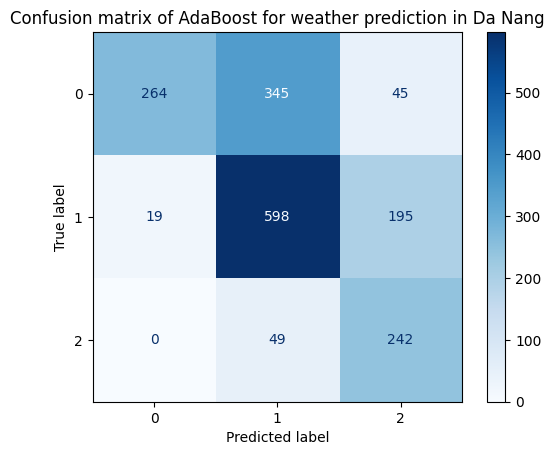

In [1192]:
# 9. Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_test_pred, labels= labels)

display = ConfusionMatrixDisplay(
    confusion_matrix= cm,
    display_labels= labels
)

plt.figure(figsize= (6,6))
display.plot(cmap= plt.cm.Blues, values_format= "d")
plt.title("Confusion matrix of AdaBoost for weather prediction in Da Nang")
plt.show()

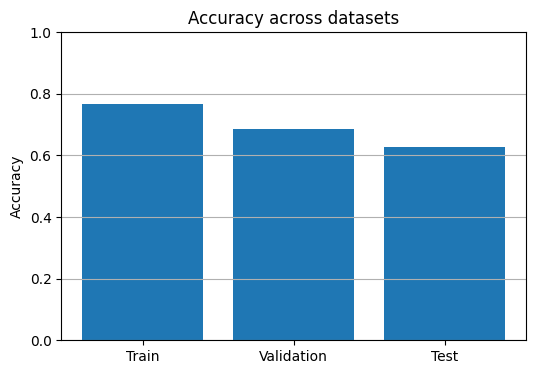

In [1193]:
sets = ["Train", "Validation", "Test"]
accuracies = [
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_val, y_val_pred),
    accuracy_score(y_test, y_test_pred)
]

plt.figure(figsize=(6,4))
plt.bar(sets, accuracies)
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.title("Accuracy across datasets")
plt.grid(axis='y')
plt.show()


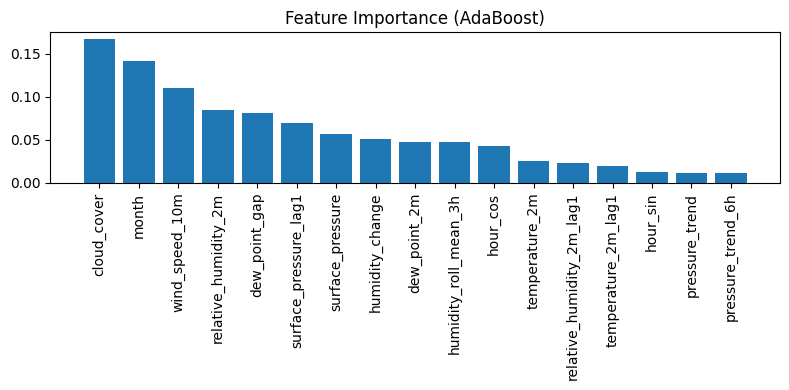

In [1194]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)),
           X_train.columns[indices],
           rotation=90)
plt.title("Feature Importance (AdaBoost)")
plt.tight_layout()
plt.show()


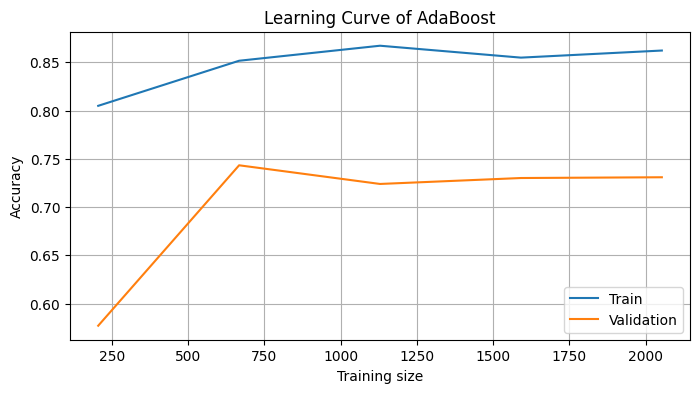

In [1195]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_scaled, y_train,
    cv=TimeSeriesSplit(5),
    scoring='accuracy',
    n_jobs=-1
)

plt.figure(figsize=(8,4))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.title("Learning Curve of AdaBoost")
plt.legend()
plt.grid(True)
plt.show()
